In [2]:
from os import path, listdir, environ, mkdir
import numpy as np
import pandas as pd
from pyteomics import fasta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.sandbox.stats.multicomp
sns.set_style('whitegrid')
# del environ['MPLBACKEND']
from collections import Counter
from matplotlib_venn import venn3, venn2
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import scipy

M3/M2
M2/M1
M1/M3


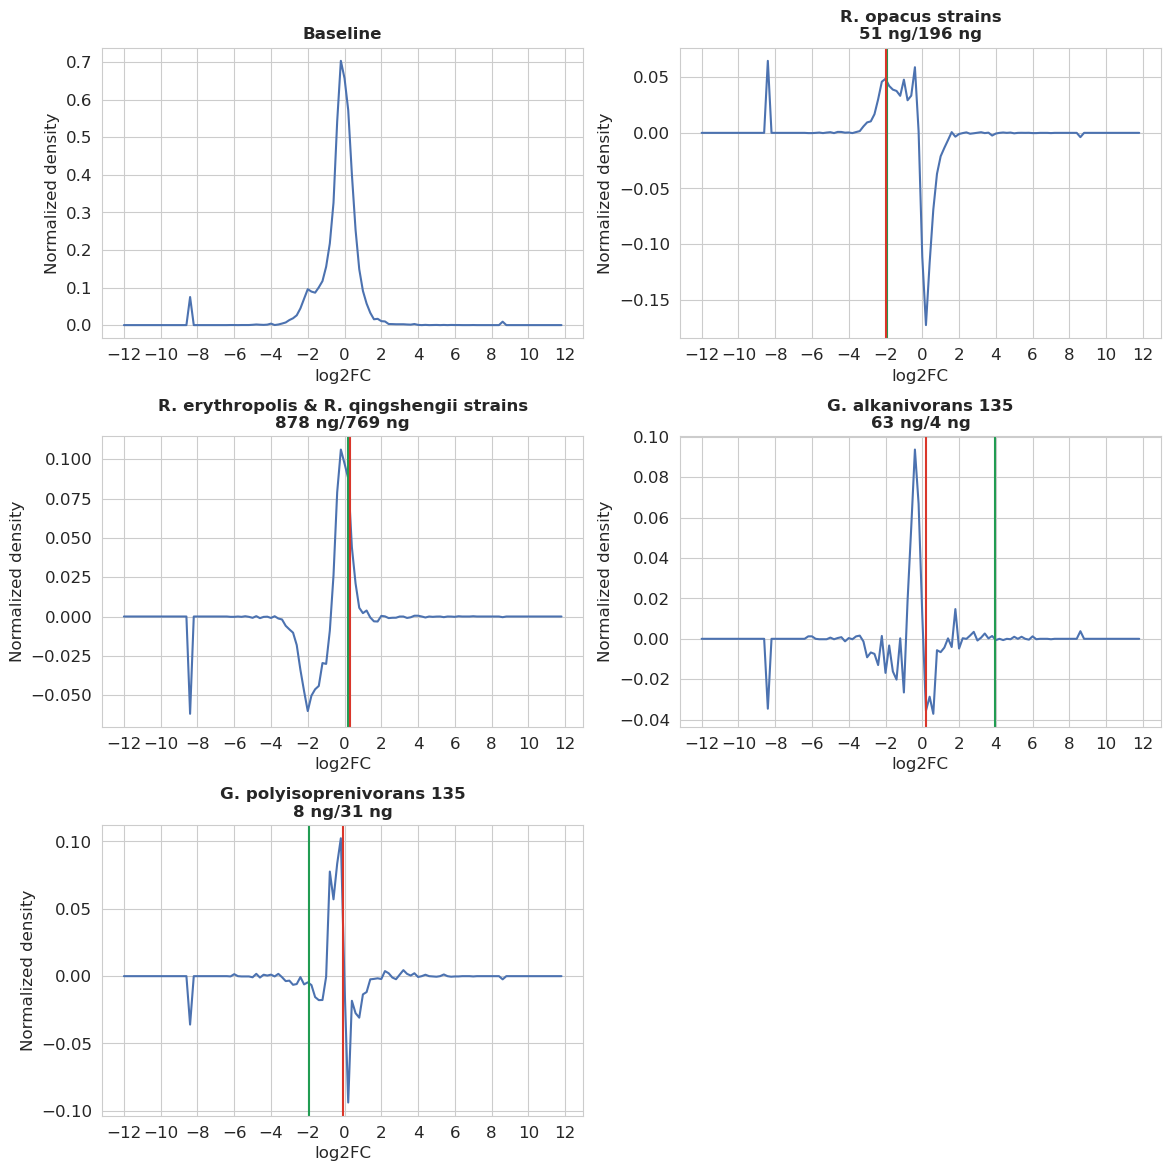

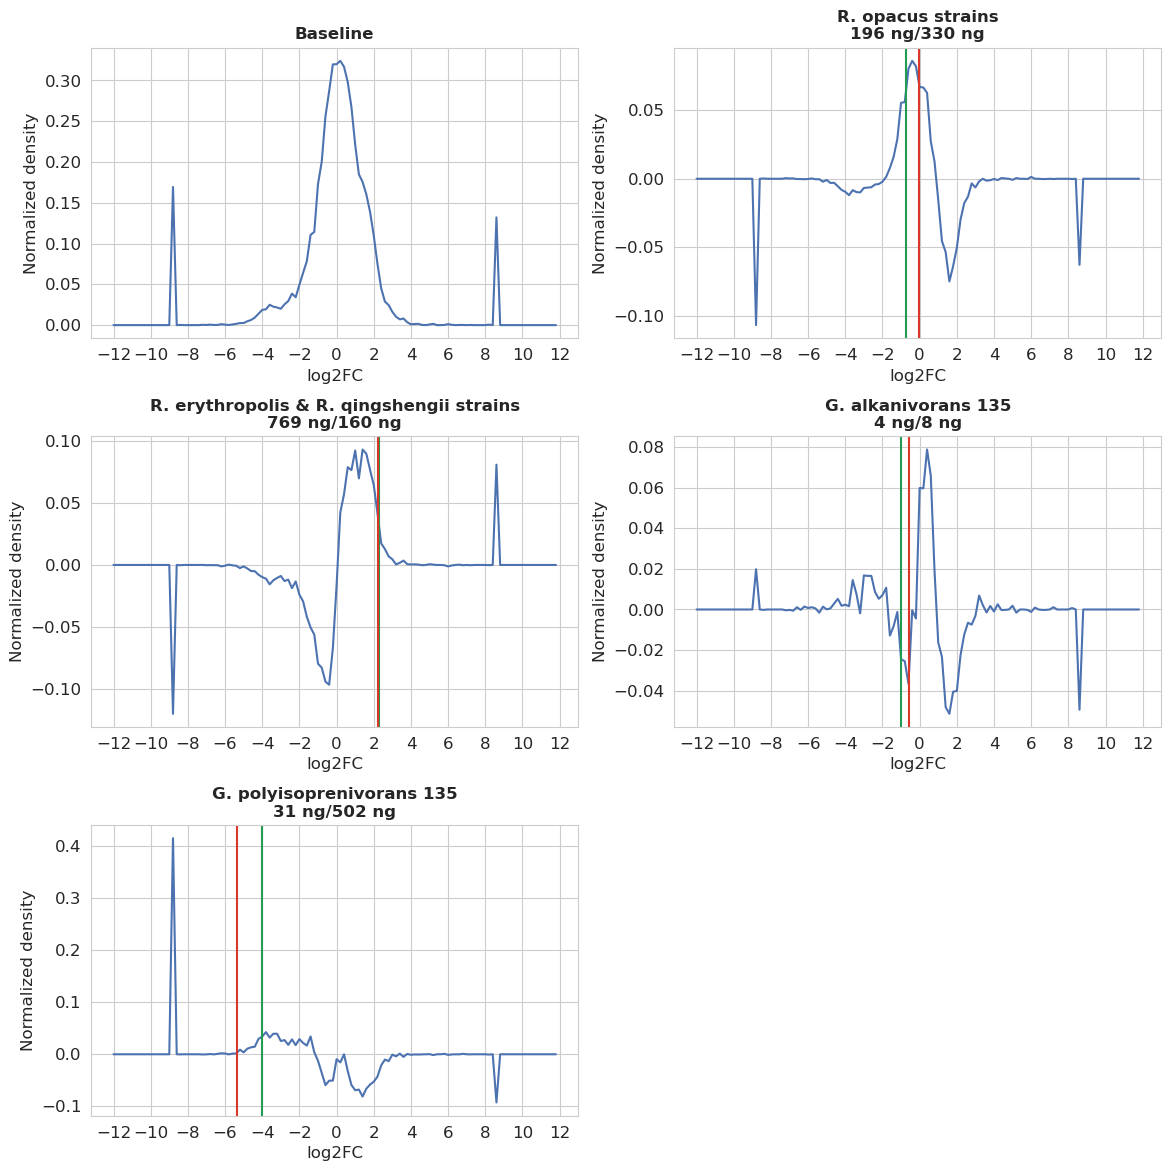

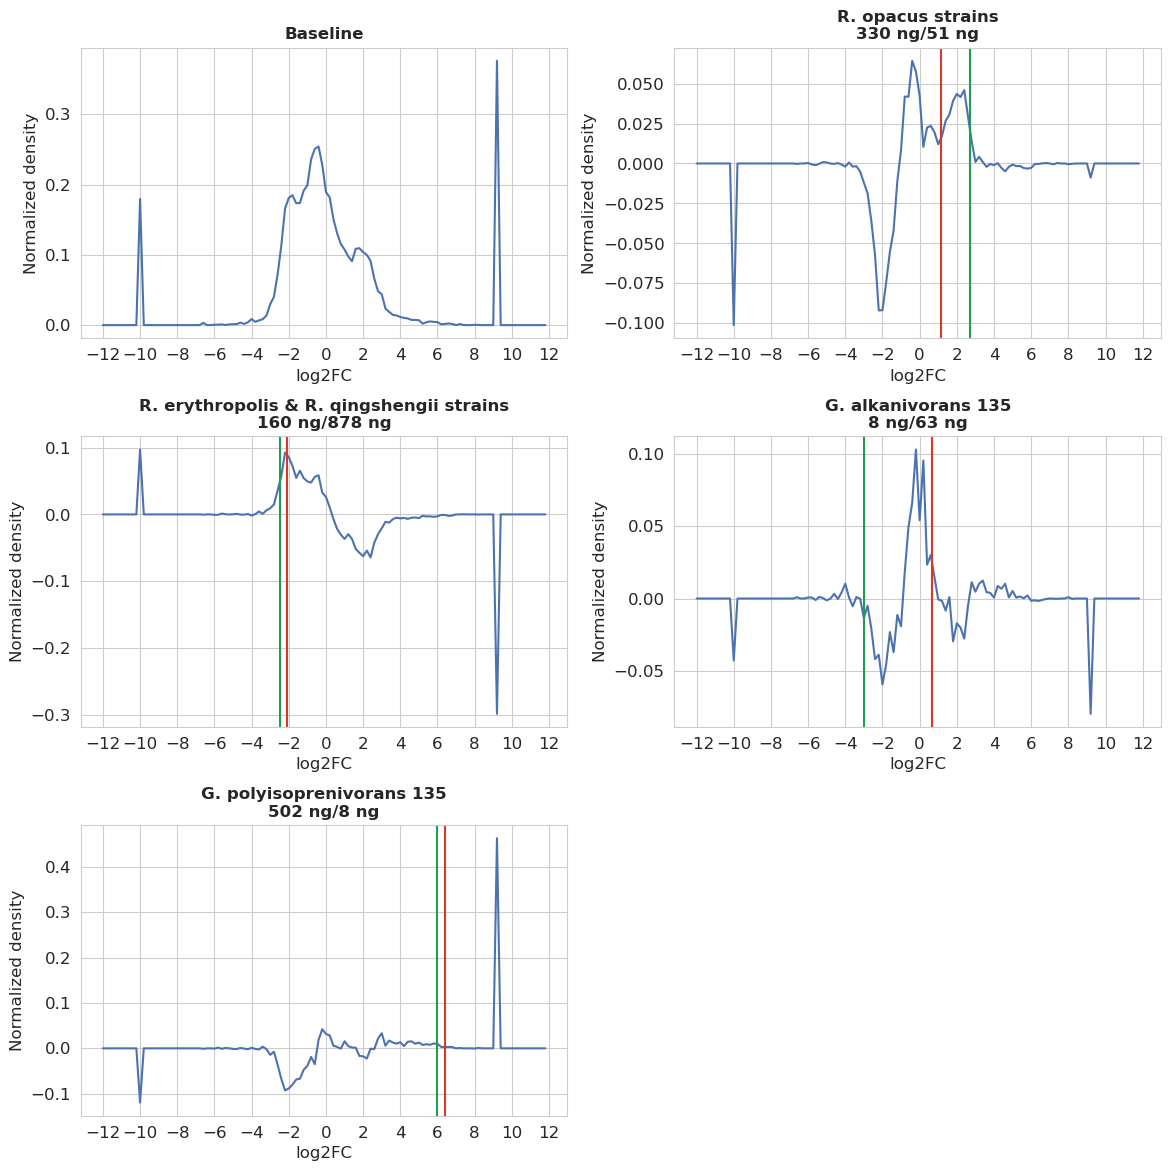

In [128]:
filedir = '/home/kae-13-1/bact_Denmark_Oct2021/2023-12-18_ms1quant_experimental'

strains = ['RHOOP',
           'GORAL', 
            'BACAR']
strains_dict = {'RHOOP': 'R.opacus 1CP',
               'GORAL': 'G. alkanivorans 135',
               'BACAR' : 'P. aryabhattai 25',
               'RHOER' : 'R. erythropolis X5',
               'GORAM':'Gordonia amicalis 6-1'}

color_vline = sns.color_palette('RdYlGn', 8)[7]
color_dist = sns.color_palette()[0]
fc_orig = pd.read_excel('/home/kae-13-1/bact_Denmark_Oct2021/2023-05-31_ms1quant/theoretical_from_masses_modelbiome1_simple.xlsx', index_col = 0)
fc_act = fc_orig
fc_orig = fc_act.T
fc_act['M1/M2'] = fc_act['M1']/fc_act['M2']
fc_act['M2/M3'] = fc_act['M2']/fc_act['M3']
fc_act['M3/M1'] = fc_act['M3']/fc_act['M1']
fc_act = fc_act.drop(columns = ['M1', 'M2', 'M3'])
fc_act = fc_act.apply(lambda x: np.log2(x))

for file in listdir(filedir):
    if file.endswith('_quant_peptides.tsv') and ('M4' not in file) and ('M5' not in file) and ('ABRF' not in file):
        comp = '/'.join(file.split('_out_')[1].split('_quant')[0].split('_'))
        
        print(comp)
        
    
        fig, ax = plt.subplots(2, 2, figsize = (30/2.54, 20/2.54))
        
        df = pd.read_csv(path.join(filedir, file), sep = '\t')
        
        df_base = df[df['decoy'] == False].copy()
        df_base = df_base.drop_duplicates(subset='peptide')
        
        baseline = np.histogram(df_base['FC'].tolist(), bins = 120, range = (-12, 12), density = True)
        sns.lineplot(x = baseline[1][:-1], y = baseline[0], ax = ax[0][0], color = color_dist)
        ax[0][0].set_title('Baseline', fontsize = 12, fontweight = 'bold')
        ax[0][0].tick_params(axis ='both', labelsize = 12)
        ax[0][0].set_xlabel('log2FC', fontsize = 12)
        ax[0][0].set_ylabel('Normalized density', fontsize = 12)
        i=1
        
        for s in strains:
            tmp_df = df[df['proteins'].apply(lambda x: x.split('_')[1] in s)].copy()
            tmp_df = tmp_df.drop_duplicates(subset='peptide')
            pepts = np.histogram(tmp_df[tmp_df['decoy'] == False]['FC'].tolist(), 
                                 bins = 120, range = (-12, 12), density = True)
            fin = pepts[0]- baseline[0]
           
            pepts_custom = pepts[1][1:] + (pepts[1][1] - pepts[1][0])/2
            
            exp_value2 = np.average(pepts_custom, weights=fin.clip(0, 1e6))
            
            
            up = comp.split('/')[0]
            down = comp.split('/')[1]
            max_mass = np.max([int(fc_orig.loc[up, s]), int(fc_orig.loc[down, s])])
            
            fc_exp = pd.concat([fc_exp, pd.DataFrame.from_dict({'comp':[comp], 
                                                               's': [s], 
                                                               'e_value':[exp_value2],
                                                               't_value' : [fc_act.loc[s, comp]],
                                                               'mass':[max_mass]})])
            
            sns.lineplot(x = pepts[1][:-1],  y = fin, ax = ax[i//2][i%2], color = color_dist)
            title = ' '.join(strains_dict[s]) + '\n'
          
            title += '{} ng/{} ng'.format(int(fc_orig.loc[up, s]), int(fc_orig.loc[down, s]))
            ax[i//2][i%2].set_title(title, fontsize = 12, fontweight = 'bold')
            ax[i//2][i%2].tick_params(axis ='both', labelsize = 12)
            ax[i//2][i%2].axvline(x = fc_act.loc[s, comp], color = color_vline)
            ax[i//2][i%2].axvline(x = exp_value2, color = color_vline2)
            ax[i//2][i%2].set_xlabel('log2FC', fontsize = 12)
            ax[i//2][i%2].set_ylabel('Normalized density', fontsize = 12)
            i+=1


            
        for j in range(4):
            ax[j//2][j%2].xaxis.set_major_locator(MultipleLocator(2))
            ax[j//2][j%2].grid(which = 'minor')
            
        fig.tight_layout()
        fig.show()